# AI Controller Development

This notebook develops and tests an AI controller for autonomous agent decision-making in the 3D world environment.

## Overview
- Train intelligent agents using reinforcement learning
- Integrate with Three.js world and LLM system
- Test decision-making algorithms
- Visualize agent behavior and performance

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Utilities
from collections import deque
import random

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)  # type: ignore
random.seed(SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

Using device: cpu


State shape: (9,)
State: [0.5        0.5        0.88       0.56       1.         1.
 1.         0.17204651 1.        ]
Action space size: 8


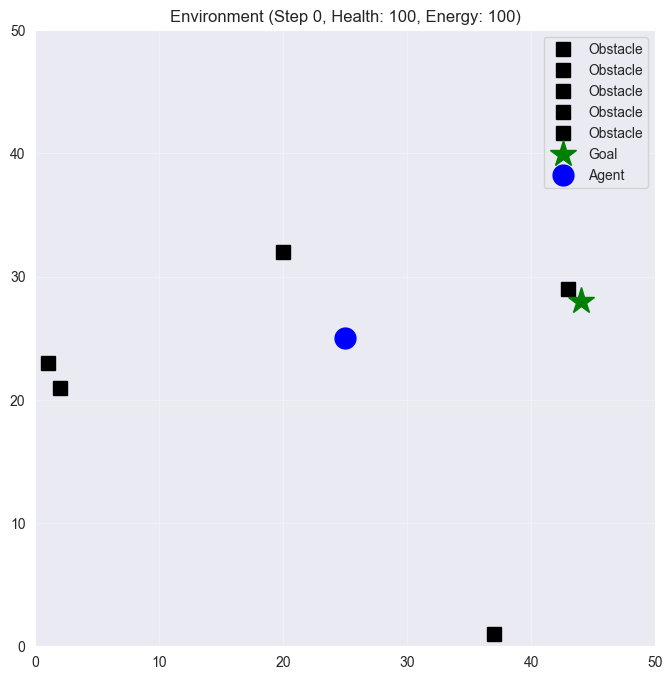

In [3]:
class AgentEnvironment:
    """
    Simulated environment for training AI controller
    """
    def __init__(self, grid_size: int = 50):
        self.grid_size = grid_size
        self.agent_pos = np.array([grid_size // 2, grid_size // 2], dtype=float)
        self.goal_pos = None
        self.obstacles: list[np.ndarray] = []
        self.threats: list[np.ndarray] = []
        self.agent_health = 100
        self.agent_energy = 100
        self.steps = 0
        self.max_steps = 200
        
        # State space: [pos_x, pos_y, goal_x, goal_y, health, energy, 
        #                threat_dist, obstacle_dist, steps_remaining]
        self.state_size = 9
        
        # Action space: 8 discrete actions
        self.action_size = 8
        self.actions = {
            0: 'move_up',
            1: 'move_down',
            2: 'move_left',
            3: 'move_right',
            4: 'move_toward_goal',
            5: 'flee_threat',
            6: 'rest',
            7: 'explore'
        }
        
        self.reset()
    
    def reset(self):
        """Reset environment to initial state"""
        self.agent_pos = np.array([self.grid_size // 2, self.grid_size // 2], dtype=float)
        self.goal_pos = np.array([
            np.random.randint(5, self.grid_size - 5),
            np.random.randint(5, self.grid_size - 5)
        ], dtype=float)
        
        # Random obstacles
        self.obstacles = [
            np.array([np.random.randint(0, self.grid_size), 
                     np.random.randint(0, self.grid_size)])
            for _ in range(5)
        ]
        
        # Random threats
        self.threats = []
        if np.random.random() < 0.3:
            self.threats.append(
                np.array([np.random.randint(0, self.grid_size),
                         np.random.randint(0, self.grid_size)])
            )
        
        self.agent_health = 100
        self.agent_energy = 100
        self.steps = 0
        
        return self._get_state()
    
    def _get_state(self):
        """Get current state vector"""
        # Distance to goal
        goal_dist = np.linalg.norm(self.agent_pos - self.goal_pos)
        
        # Distance to nearest threat
        threat_dist = 50
        if self.threats:
            threat_dist = min([np.linalg.norm(self.agent_pos - t) for t in self.threats])
        
        # Distance to nearest obstacle
        obstacle_dist = 50
        if self.obstacles:
            obstacle_dist = min([np.linalg.norm(self.agent_pos - o) for o in self.obstacles])
        
        state = np.array([
            self.agent_pos[0] / self.grid_size,
            self.agent_pos[1] / self.grid_size,
            self.goal_pos[0] / self.grid_size,
            self.goal_pos[1] / self.grid_size,
            self.agent_health / 100,
            self.agent_energy / 100,
            min(threat_dist / 50, 1.0),
            min(obstacle_dist / 50, 1.0),
            (self.max_steps - self.steps) / self.max_steps
        ])
        
        return state
    
    def step(self, action):
        """Execute action and return next state, reward, done"""
        self.steps += 1
        reward = -0.1  # Small penalty per step
        
        # Execute action
        if action == 0:  # move_up
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.grid_size - 1)
            self.agent_energy -= 0.5
        elif action == 1:  # move_down
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
            self.agent_energy -= 0.5
        elif action == 2:  # move_left
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)
            self.agent_energy -= 0.5
        elif action == 3:  # move_right
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.grid_size - 1)
            self.agent_energy -= 0.5
        elif action == 4:  # move_toward_goal
            direction = self.goal_pos - self.agent_pos
            if np.linalg.norm(direction) > 0:
                direction = direction / np.linalg.norm(direction)
                self.agent_pos += direction * 2
                self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size - 1)
            self.agent_energy -= 1
            reward += 0.5  # Reward for moving toward goal
        elif action == 5:  # flee_threat
            if self.threats:
                nearest_threat = min(self.threats, key=lambda t: np.linalg.norm(self.agent_pos - t))
                direction = self.agent_pos - nearest_threat
                if np.linalg.norm(direction) > 0:
                    direction = direction / np.linalg.norm(direction)
                    self.agent_pos += direction * 2
                    self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size - 1)
            self.agent_energy -= 1.5
        elif action == 6:  # rest
            self.agent_energy = min(100, self.agent_energy + 10)
            reward += 0.2
        elif action == 7:  # explore
            self.agent_pos += np.random.randn(2) * 2
            self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size - 1)
            self.agent_energy -= 0.3
        
        # Check threats
        for threat in self.threats:
            if np.linalg.norm(self.agent_pos - threat) < 3:
                self.agent_health -= 10
                reward -= 5
        
        # Check obstacles
        for obstacle in self.obstacles:
            if np.linalg.norm(self.agent_pos - obstacle) < 1:
                reward -= 1
        
        # Check goal
        goal_dist = np.linalg.norm(self.agent_pos - self.goal_pos)
        if goal_dist < 2:
            reward += 100
            done = True
        else:
            reward += (50 - goal_dist) * 0.1  # Reward for getting closer
            done = False
        
        # Check termination conditions
        if self.agent_health <= 0 or self.agent_energy <= 0:
            reward -= 50
            done = True
        elif self.steps >= self.max_steps:
            done = True
        
        next_state = self._get_state()
        
        return next_state, reward, done
    
    def render(self):
        """Visualize the environment"""
        plt.figure(figsize=(8, 8))
        
        # Grid
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        
        # Obstacles
        for obs in self.obstacles:
            plt.plot(obs[0], obs[1], 'ks', markersize=10, label='Obstacle')
        
        # Threats
        for threat in self.threats:
            plt.plot(threat[0], threat[1], 'rs', markersize=15, label='Threat')
        
        # Goal
        plt.plot(self.goal_pos[0], self.goal_pos[1], 'g*', markersize=20, label='Goal')
        
        # Agent
        plt.plot(self.agent_pos[0], self.agent_pos[1], 'bo', markersize=15, label='Agent')
        
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title(f'Environment (Step {self.steps}, Health: {self.agent_health:.0f}, Energy: {self.agent_energy:.0f})')
        plt.show()

# Test the environment
env = AgentEnvironment()
state = env.reset()
print(f"State shape: {state.shape}")
print(f"State: {state}")
print(f"Action space size: {env.action_size}")
env.render()

In [4]:
class DQNetwork(nn.Module):
    """Deep Q-Network for action-value estimation"""
    
    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class ReplayBuffer:
    """Experience replay buffer for stable training"""
    
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            torch.FloatTensor(np.array(states)),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(np.array(next_states)),
            torch.FloatTensor(dones)
        )
    
    def __len__(self):
        return len(self.buffer)


class AIController:
    """AI Controller using DQN"""
    
    def __init__(self, state_size, action_size, config=None):
        self.state_size = state_size
        self.action_size = action_size
        
        # Hyperparameters
        self.config = config or {
            'learning_rate': 0.001,
            'gamma': 0.99,
            'epsilon_start': 1.0,
            'epsilon_end': 0.01,
            'epsilon_decay': 0.995,
            'batch_size': 64,
            'target_update': 10
        }
        
        # Networks
        self.policy_net = DQNetwork(state_size, action_size).to(device)
        self.target_net = DQNetwork(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(
            self.policy_net.parameters(),
            lr=self.config['learning_rate']
        )
        
        # Replay buffer
        self.memory = ReplayBuffer(capacity=10000)
        
        # Training state
        self.epsilon = self.config['epsilon_start']
        self.episode = 0
        self.total_steps = 0
        
        # Metrics
        self.training_rewards = []
        self.training_losses = []
        
    def select_action(self, state, training=True):
        """Select action using epsilon-greedy policy"""
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()
    
    def train_step(self):
        """Perform one training step"""
        if len(self.memory) < self.config['batch_size']:
            return None
        
        states, actions, rewards, next_states, dones = self.memory.sample(
            self.config['batch_size']
        )
        
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        dones = dones.to(device)
        
        # Current Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Target Q values
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.config['gamma'] * next_q
        
        # Compute loss
        loss = F.mse_loss(current_q.squeeze(), target_q)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        """Copy policy network weights to target network"""
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(
            self.config['epsilon_end'],
            self.epsilon * self.config['epsilon_decay']
        )

# Initialize controller
controller = AIController(env.state_size, env.action_size)
print(f"Controller initialized")
print(f"Policy network: {controller.policy_net}")
print(f"Starting epsilon: {controller.epsilon}")

Controller initialized
Policy network: DQNetwork(
  (fc1): Linear(in_features=9, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=8, bias=True)
)
Starting epsilon: 1.0


In [5]:
def train_agent(controller, env, num_episodes=100, verbose=True):
    """
    Train the AI controller in the environment
    
    Args:
        controller: AIController instance
        env: AgentEnvironment instance
        num_episodes: Number of training episodes
        verbose: Print progress
    
    Returns:
        Training history
    """
    episode_rewards = []
    episode_lengths = []
    episode_losses = []
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_loss = []
        done = False
        
        while not done:
            # Select action
            action = controller.select_action(state, training=True)
            
            # Execute action
            next_state, reward, done = env.step(action)
            episode_reward += reward
            
            # Store transition
            controller.memory.push(state, action, reward, next_state, done)
            
            # Train
            loss = controller.train_step()
            if loss is not None:
                episode_loss.append(loss)
            
            state = next_state
            controller.total_steps += 1
        
        # Update target network periodically
        if episode % controller.config['target_update'] == 0:
            controller.update_target_network()
        
        # Decay epsilon
        controller.decay_epsilon()
        controller.episode += 1
        
        # Record metrics
        episode_rewards.append(episode_reward)
        episode_lengths.append(env.steps)
        avg_loss = np.mean(episode_loss) if episode_loss else 0
        episode_losses.append(avg_loss)
        
        controller.training_rewards.append(episode_reward)
        controller.training_losses.append(avg_loss)
        
        if verbose and (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_length = np.mean(episode_lengths[-10:])
            avg_loss_10 = np.mean(episode_losses[-10:])
            print(f"Episode {episode + 1}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Length: {avg_length:.1f} | "
                  f"Loss: {avg_loss_10:.4f} | "
                  f"ε: {controller.epsilon:.3f}")
    
    return {
        'rewards': episode_rewards,
        'lengths': episode_lengths,
        'losses': episode_losses
    }

print("Training function defined. Ready to train!")

Training function defined. Ready to train!


In [ ]:
# Train the controller
print("Starting training...")
print(f"Training for 200 episodes\n")

training_history = train_agent(controller, env, num_episodes=200, verbose=True)

print("\nTraining complete!")
print(f"Final epsilon: {controller.epsilon:.3f}")
print(f"Total steps: {controller.total_steps}")
print(f"Final 10 episode average reward: {np.mean(training_history['rewards'][-10:]):.2f}")

Starting training...
Training for 200 episodes

Episode 10/200 | Avg Reward: 317.38 | Avg Length: 62.4 | Loss: 75.1060 | ε: 0.951
Episode 20/200 | Avg Reward: 218.67 | Avg Length: 32.2 | Loss: 133.3205 | ε: 0.905
Episode 30/200 | Avg Reward: 256.81 | Avg Length: 41.6 | Loss: 125.6797 | ε: 0.860
Episode 40/200 | Avg Reward: 207.42 | Avg Length: 27.2 | Loss: 85.6892 | ε: 0.818
Episode 50/200 | Avg Reward: 210.27 | Avg Length: 28.0 | Loss: 76.9359 | ε: 0.778
Episode 60/200 | Avg Reward: 190.71 | Avg Length: 23.2 | Loss: 63.3397 | ε: 0.740
Episode 70/200 | Avg Reward: 161.28 | Avg Length: 15.3 | Loss: 56.7911 | ε: 0.704
Episode 80/200 | Avg Reward: 171.74 | Avg Length: 18.4 | Loss: 36.2498 | ε: 0.670
Episode 90/200 | Avg Reward: 171.45 | Avg Length: 17.6 | Loss: 23.7087 | ε: 0.637
Episode 100/200 | Avg Reward: 167.17 | Avg Length: 17.7 | Loss: 17.1993 | ε: 0.606
Episode 110/200 | Avg Reward: 157.76 | Avg Length: 14.7 | Loss: 9.4339 | ε: 0.576
Episode 120/200 | Avg Reward: 175.30 | Avg Leng

In [ ]:
def test_agent(controller, env, num_episodes=10, render_last=True):
    """
    Test the trained agent
    
    Args:
        controller: Trained AIController
        env: AgentEnvironment
        num_episodes: Number of test episodes
        render_last: Whether to render the last episode
    
    Returns:
        Test results
    """
    test_rewards = []
    test_lengths = []
    success_count = 0
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            # Select action (no exploration)
            action = controller.select_action(state, training=False)
            
            # Execute action
            next_state, reward, done = env.step(action)
            episode_reward += reward
            state = next_state
        
        test_rewards.append(episode_reward)
        test_lengths.append(env.steps)
        
        # Check if goal was reached
        goal_dist = np.linalg.norm(env.agent_pos - env.goal_pos)
        if goal_dist < 2:
            success_count += 1
        
        print(f"Test Episode {episode + 1}: "
              f"Reward={episode_reward:.2f}, "
              f"Steps={env.steps}, "
              f"Goal Distance={goal_dist:.2f}")
        
        # Render last episode
        if render_last and episode == num_episodes - 1:
            env.render()
    
    print(f"\nTest Results:")
    print(f"Average Reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
    print(f"Average Steps: {np.mean(test_lengths):.1f}")
    print(f"Success Rate: {success_count / num_episodes * 100:.1f}%")
    
    return {
        'rewards': test_rewards,
        'lengths': test_lengths,
        'success_rate': success_count / num_episodes
    }

# Test the trained agent
print("Testing trained agent...\n")
test_results = test_agent(controller, env, num_episodes=10, render_last=True)

In [ ]:
# Visualize training progress
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Episode Rewards
axes[0, 0].plot(training_history['rewards'], alpha=0.6, label='Raw')
# Smooth with moving average
window = 10
if len(training_history['rewards']) >= window:
    rewards_smooth = pd.Series(training_history['rewards']).rolling(window).mean()
    axes[0, 0].plot(rewards_smooth, linewidth=2, label=f'{window}-episode MA')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].set_title('Training Rewards Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Episode Lengths
axes[0, 1].plot(training_history['lengths'], alpha=0.6, label='Raw')
if len(training_history['lengths']) >= window:
    lengths_smooth = pd.Series(training_history['lengths']).rolling(window).mean()
    axes[0, 1].plot(lengths_smooth, linewidth=2, label=f'{window}-episode MA')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].set_title('Episode Length Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Training Loss
axes[1, 0].plot(controller.training_losses, alpha=0.6, label='Raw')
if len(controller.training_losses) >= window:
    loss_smooth = pd.Series(controller.training_losses).rolling(window).mean()
    axes[1, 0].plot(loss_smooth, linewidth=2, label=f'{window}-episode MA')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Reward Distribution
axes[1, 1].hist(training_history['rewards'], bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(np.mean(training_history['rewards']), 
                   color='r', linestyle='--', linewidth=2, label='Mean')
axes[1, 1].set_xlabel('Episode Reward')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Reward Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Training Summary ===")
print(f"Total episodes: {len(training_history['rewards'])}")
print(f"Total steps: {controller.total_steps}")
print(f"\nRewards:")
print(f"  Mean: {np.mean(training_history['rewards']):.2f}")
print(f"  Std: {np.std(training_history['rewards']):.2f}")
print(f"  Max: {np.max(training_history['rewards']):.2f}")
print(f"  Min: {np.min(training_history['rewards']):.2f}")
print(f"\nLast 20 episodes:")
print(f"  Avg reward: {np.mean(training_history['rewards'][-20:]):.2f}")
print(f"  Avg length: {np.mean(training_history['lengths'][-20:]):.1f}")

In [ ]:
# Analyze Q-values for different states
def visualize_q_values(controller, env, num_samples=5):
    """Visualize Q-values for sample states"""
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    
    for i in range(num_samples):
        state = env.reset()
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = controller.policy_net(state_tensor).cpu().numpy()[0]
        
        # Plot Q-values
        axes[i].bar(range(env.action_size), q_values)
        axes[i].set_xlabel('Action')
        axes[i].set_ylabel('Q-Value')
        axes[i].set_title(f'Sample {i+1}\\n'
                         f'H:{env.agent_health:.0f} E:{env.agent_energy:.0f}\\n'
                         f'Threats:{len(env.threats)}')
        axes[i].set_xticks(range(env.action_size))
        axes[i].set_xticklabels([env.actions[a][:8] for a in range(env.action_size)], 
                                rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3, axis='y')
        
        # Highlight best action
        best_action = q_values.argmax()
        axes[i].patches[best_action].set_color('green')
        axes[i].patches[best_action].set_alpha(0.8)
    
    plt.tight_layout()
    plt.suptitle('Q-Value Analysis for Different States', y=1.02, fontsize=14)
    plt.show()

visualize_q_values(controller, env, num_samples=5)

# Action distribution analysis
print("\n=== Action Distribution During Testing ===")
action_counts = np.zeros(env.action_size)

for _ in range(50):
    state = env.reset()
    done = False
    while not done:
        action = controller.select_action(state, training=False)
        action_counts[action] += 1
        next_state, reward, done = env.step(action)
        state = next_state

# Plot action distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(range(env.action_size), action_counts)
plt.xlabel('Action', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Action Selection Frequency (50 Test Episodes)', fontsize=14)
plt.xticks(range(env.action_size), 
          [env.actions[a] for a in range(env.action_size)], 
          rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Color bars
colors = plt.cm.viridis(action_counts / action_counts.max())
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.tight_layout()
plt.show()

print("\nAction frequencies:")
for action_id, count in enumerate(action_counts):
    percentage = count / action_counts.sum() * 100
    print(f"{env.actions[action_id]:20s}: {count:4.0f} ({percentage:5.1f}%)")

In [ ]:
# Create directory for models
model_dir = Path('ai_training/controller/models')
model_dir.mkdir(parents=True, exist_ok=True)

# Save PyTorch checkpoint
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_path = model_dir / f'controller_{timestamp}.pth'

checkpoint = {
    'episode': controller.episode,
    'total_steps': controller.total_steps,
    'policy_net_state': controller.policy_net.state_dict(),
    'target_net_state': controller.target_net.state_dict(),
    'optimizer_state': controller.optimizer.state_dict(),
    'epsilon': controller.epsilon,
    'config': controller.config,
    'training_rewards': controller.training_rewards,
    'training_losses': controller.training_losses,
    'state_size': controller.state_size,
    'action_size': controller.action_size
}

torch.save(checkpoint, checkpoint_path)
print(f"✓ Checkpoint saved: {checkpoint_path}")

# Export weights as JSON for JavaScript
weights_export = {}
for name, param in controller.policy_net.state_dict().items():
    weights_export[name] = param.cpu().numpy().tolist()

export_data = {
    'weights': weights_export,
    'config': controller.config,
    'state_size': controller.state_size,
    'action_size': controller.action_size,
    'actions': env.actions,
    'training_stats': {
        'episodes': controller.episode,
        'total_steps': controller.total_steps,
        'final_epsilon': controller.epsilon,
        'avg_reward_last_20': float(np.mean(controller.training_rewards[-20:])),
        'test_success_rate': test_results['success_rate']
    }
}

json_path = model_dir / f'controller_weights_{timestamp}.json'
with open(json_path, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"✓ Weights exported: {json_path}")

# Save latest version
latest_path = model_dir / 'controller_latest.pth'
torch.save(checkpoint, latest_path)
print(f"✓ Latest checkpoint: {latest_path}")

latest_json = model_dir / 'controller_latest.json'
with open(latest_json, 'w') as f:
    json.dump(export_data, f, indent=2)
print(f"✓ Latest weights: {latest_json}")

print("\n=== Model Export Complete ===")
print(f"Files saved in: {model_dir.absolute()}")
print(f"\\nTo use in JavaScript:")
print(f"  1. Load weights from: {latest_json}")
print(f"  2. Import AIController from public/AIController.js")
print(f"  3. Initialize with loaded weights")

## Next Steps

### Integration with Three.js World
1. Load [public/AIController.js](public/AIController.js) in your game
2. Register agents using `controller.registerAgent()`
3. Call `controller.start()` to begin autonomous behavior

### Training Improvements
- Collect real gameplay data from the 3D world
- Fine-tune with actual agent interactions
- Run [ai_controller_trainer.py](ai_controller_trainer.py) for advanced training

### Further Development
- Add more complex behaviors (cooperation, communication)
- Implement multi-agent scenarios
- Integrate with LLM for natural language reasoning
- Add memory and learning from past experiences

Run this notebook again anytime to retrain and improve the AI controller!

## 9. Save and Export Model

Save the trained controller for deployment in the web application.

## 8. Analyze Decision Making

Visualize Q-values and action preferences to understand the agent's decision-making process.

## 7. Visualize Performance

Create comprehensive visualizations of the AI controller's learning progress and decision-making.

## 6. Test the AI Controller

Evaluate the trained controller's performance on test scenarios.

## 5. Train the AI Controller

Train the agent for multiple episodes and observe learning progress.

## 4. Implement Decision Making Logic

Implement the training loop that allows the agent to learn from experience through trial and error.

## 3. Create the AI Controller Class

Define the Deep Q-Network (DQN) architecture and experience replay buffer for the AI controller.

## 2. Define the Environment

Set up the simulation environment where the AI agent will operate. This includes state space (agent observations) and action space (possible actions).

## 1. Import Required Libraries

Import necessary libraries for reinforcement learning, neural networks, and data processing.